In [53]:
#importação das libs
import numpy as np
import pandas as pd #para manipulação de dados
import torch #principal lib do pytorch
import torch.nn as nn #definir redes neurais
import torch.optim as optim #definir otimizadores
from sklearn.preprocessing import StandardScaler #normalizar dados
from torch.utils.data import TensorDataset, DataLoader #para criar datasets e loaders
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Rodando em:", device)


Rodando em: cuda


In [54]:
# 1 - carregar datasets de treino e teste
train_df = pd.read_csv("../raw_data/UNSW_NB15_training-set.csv") #arquivo de treino
test_df = pd.read_csv("../raw_data/UNSW_NB15_testing-set.csv") #arquivo de teste


In [55]:
#drop de colunas categóricas (object)
cols_to_drop = ["id", "proto", "service", "state", "attack_cat"]

train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

In [56]:
#separar features(x) e labels(y)
x_train = train_df.drop(columns=["label"]).values #remove o label (resultado)
y_train = train_df["label"].values   #pega somente o label (resultado)

x_test = test_df.drop(columns=["label"]).values
y_test = test_df["label"].values  


In [57]:
#normalização dos dados
scaler = StandardScaler() #normalizador (média = 0 e desvio padrão = 1
x_train = scaler.fit_transform(x_train) #ajusta normalizador com treino e transforma
x_test = scaler.transform(x_test) #aplica mesmo normalizador no teste

In [58]:
#conversão para tensores do pytorch
x_train = torch.tensor(x_train, dtype=torch.float32).to(device) #features de treino em tensor float
y_train = torch.tensor(y_train, dtype=torch.long).to(device)  #labels de treino em tensor long
x_test = torch.tensor(x_test, dtype=torch.float32).to(device) 
y_test = torch.tensor(y_test, dtype=torch.long).to(device) 

In [67]:
#criação de dataloader (para mini-batches)
train_dataset = TensorDataset(x_train, y_train) #junta features + labels
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
#batch_size=64 -> divide em lotes de 64 amostras
#shuffle=True -> embaralha os dados a cada época

In [60]:
# 2 - definir rede neural feedforward (mlp)
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2):
        super(FeedForwardNN, self).__init__()
        #primeira camada: entrada -> hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU() #função de ativação ReLU
        #segunda camada: hidden_dim -> 64
        self.fc2 = nn.Linear(hidden_dim, 64)
        self.relu2 = nn.ReLU()
        #camada final: 64 -> saída (número de classes)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        #passa os dados pelas camadas na ordem definida
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x) #saída sem ativação, pois CrossEntropyLoss já aplica softmax
        return x


In [61]:
#define dimensões do modelo
input_dim = x_train.shape[1] #número de features (41 para este modelo)
output_dim = len(set(y_train.cpu().numpy())) #número de calsses distintas no dataset / usa cpu para contar classes
model = FeedForwardNN(input_dim, 128, output_dim).to(device)  #instancia o modelo

In [76]:
# 3 - configuração do treinamento
criterion = nn.CrossEntropyLoss() #função de perda para classificação
optimizer = optim.Adam(model.parameters(), lr=0.0005) #otimizador adam

In [73]:
#loop de treino
epochs = 50 #quantas vezes percorrer todo o dataset
for epoch in range(epochs):
    model.train() #coloca a rede em modo treino (ativa dropout/bn se existissem)
    total_loss = 0 #acumulador da perda
    for x_batch, y_batch in train_loader: #itera sobre os mini-batches

        x_batch, y_batch = x_batch.to(device), y_batch.to(device) 
        
        optimizer.zero_grad() #zera gradientes acumulados
        outputs = model(x_batch) #forward pass (entrada -> saída da rede)
        loss = criterion(outputs, y_batch) #calcula a perda (cross-entropy)
        loss.backward() #backpropagation (gradiente)
        total_loss += loss.item() #soma a perda deste batch

    #exibe perda média de época
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss: .4f}")


Epoch 1/50, Loss:  458.7637
Epoch 2/50, Loss:  458.7636
Epoch 3/50, Loss:  458.7642
Epoch 4/50, Loss:  458.7640
Epoch 5/50, Loss:  458.7633
Epoch 6/50, Loss:  458.7641
Epoch 7/50, Loss:  458.7639
Epoch 8/50, Loss:  458.7636
Epoch 9/50, Loss:  458.7638
Epoch 10/50, Loss:  458.7636
Epoch 11/50, Loss:  458.7640
Epoch 12/50, Loss:  458.7638
Epoch 13/50, Loss:  458.7641
Epoch 14/50, Loss:  458.7641
Epoch 15/50, Loss:  458.7637
Epoch 16/50, Loss:  458.7637
Epoch 17/50, Loss:  458.7648
Epoch 18/50, Loss:  458.7637
Epoch 19/50, Loss:  458.7646
Epoch 20/50, Loss:  458.7642
Epoch 21/50, Loss:  458.7634
Epoch 22/50, Loss:  458.7633
Epoch 23/50, Loss:  458.7642
Epoch 24/50, Loss:  458.7637
Epoch 25/50, Loss:  458.7634
Epoch 26/50, Loss:  458.7637
Epoch 27/50, Loss:  458.7638
Epoch 28/50, Loss:  458.7636
Epoch 29/50, Loss:  458.7632
Epoch 30/50, Loss:  458.7641
Epoch 31/50, Loss:  458.7639
Epoch 32/50, Loss:  458.7634
Epoch 33/50, Loss:  458.7633
Epoch 34/50, Loss:  458.7642
Epoch 35/50, Loss:  458

In [74]:
# 4 - previsão no conjunto de teste
model.eval() #coloca a rede em modo avaliação (desativa dropout/bn se houvesse)
with torch.no_grad(): #não calcula gradientes (mais rápido e economiza memória)
    outputs = model(x_test) #forward pass no conjunto de teste
    _, predicted = torch.max(outputs, 1) #pega a classe com maior probabilidade

#converter para cpu/numpy
y_true = y_test.cpu().numpy()
y_pred = predicted.cpu().numpy()
y_scores = outputs[:,1].cpu().numpy() #probabilidade da classe 1 (ataque)

In [75]:
#métricas principais
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Acurácia: {accuracy*100:.2f}%")
print(f"Precisão: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Acurácia: 53.95%
Precisão: 54.67%
Recall: 95.76%
F1-score: 69.60%


In [77]:
#matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("\nMatriz de confusão:")
print(cm)

TN, FP, FN, TP = cm.ravel()


Matriz de confusão:
[[ 1004 35996]
 [ 1920 43412]]


In [48]:
#métricas de IDS
detection_rate = TP / (TP + FN) #taxa de detecção (recall dos ataques)
false_alarm_rate = FP / (FP + TN) #taxa de falso alarme

print(f"\nDetection Rate (DR): {detection_rate*100:.2f}%")
print(f"\nFalse Alarm Rate (FAR): {detection_rate*100:.2f}%")


Detection Rate (DR): 6.95%

False Alarm Rate (FAR): 6.95%



AUC-ROC: 0.6918


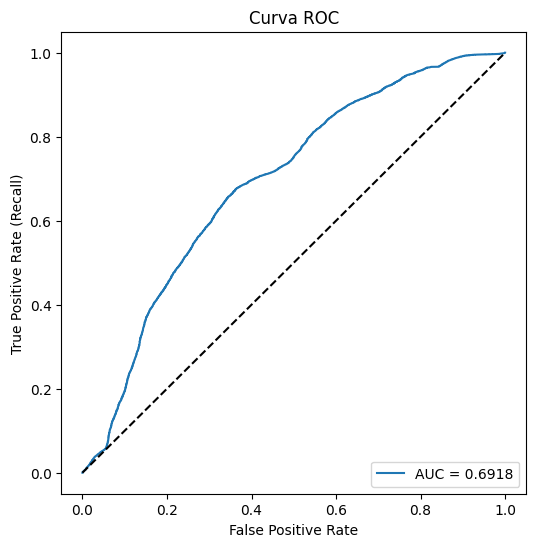

In [71]:
#ROC e AUC
auc = roc_auc_score(y_true, y_scores)
print(f"\nAUC-ROC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [52]:
print(np.unique(y_train.cpu().numpy(), return_counts=True))

(array([0, 1]), array([ 56000, 119341]))
